Nama : Tri Wahyono <br>
NIM : 211351145<br>
Kelas : Malam A

# import Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"triwahyo","key":"c03c47574a6806790e41fa3e50341e54"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d henslersoftware/19560-indian-takeaway-orders

  0% 0.00/1.31M [00:00<?, ?B/s]
100% 1.31M/1.31M [00:00<00:00, 86.7MB/s]


In [4]:
!mkdir 19560-indian-takeaway-orders
!unzip 19560-indian-takeaway-orders.zip -d datasets
!ls datasets

Archive:  19560-indian-takeaway-orders.zip
  inflating: datasets/restaurant-1-orders.csv  
  inflating: datasets/restaurant-1-products-price.csv  
  inflating: datasets/restaurant-2-orders.csv  
  inflating: datasets/restaurant-2-products-price.csv  
restaurant-1-orders.csv		 restaurant-2-orders.csv
restaurant-1-products-price.csv  restaurant-2-products-price.csv


# import library yang digunakan

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import association_rules, apriori

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Data Discovery

In [6]:
df = pd.read_csv('/content/datasets/restaurant-1-orders.csv', encoding="unicode_escape")

Tampilan 5 baris pertama dari data frame:

In [7]:
df.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Number    74818 non-null  int64  
 1   Order Date      74818 non-null  object 
 2   Item Name       74818 non-null  object 
 3   Quantity        74818 non-null  int64  
 4   Product Price   74818 non-null  float64
 5   Total products  74818 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


Dimensi dari data frame

In [9]:
df.shape

(74818, 6)

Mari kita lihat jumlah data unik pada setiap kolom

In [10]:
df.nunique()

Order Number      13397
Order Date        13081
Item Name           248
Quantity             22
Product Price        16
Total products       32
dtype: int64

# EDA

Tampilkan 10 produk yang paling laris

<function matplotlib.pyplot.show(close=None, block=None)>

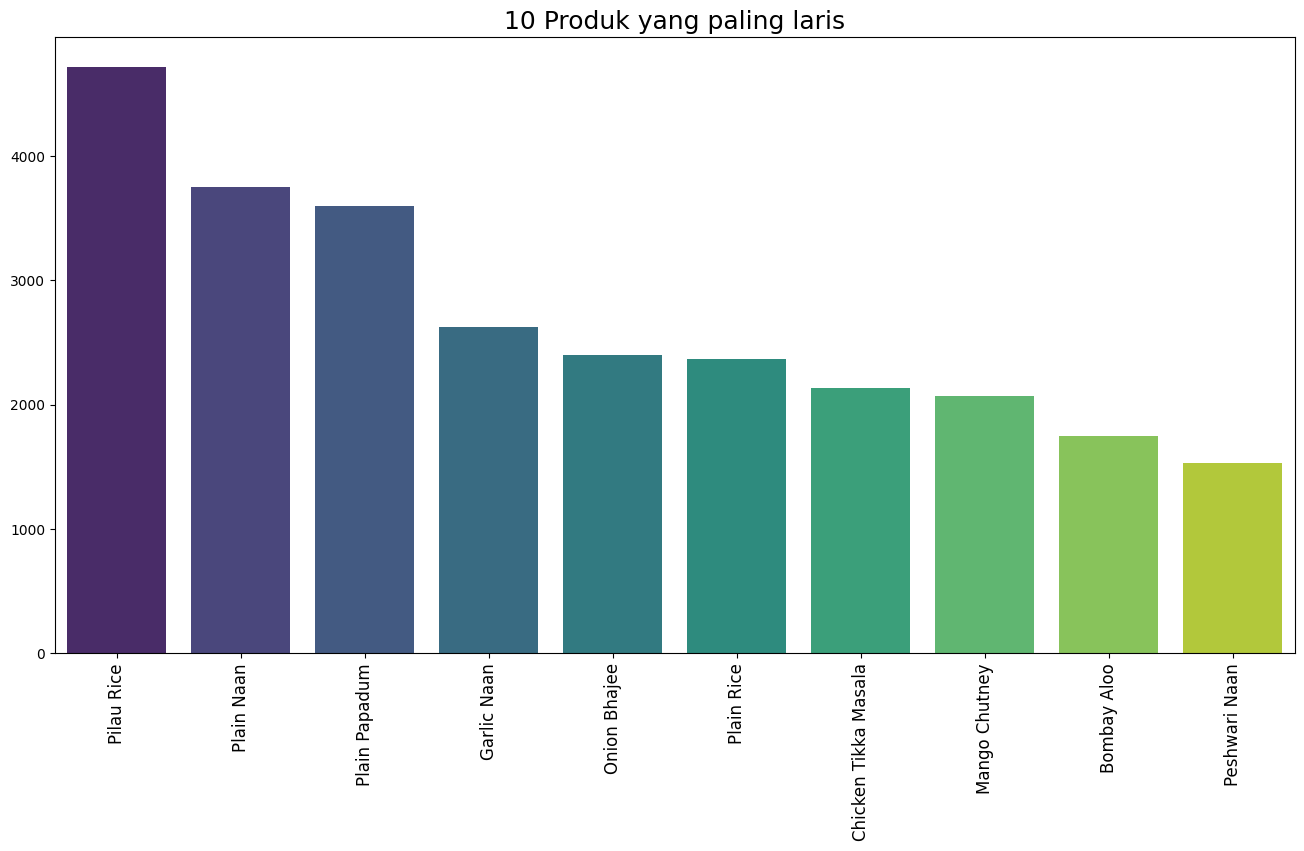

In [11]:
plt.figure(figsize=(16,8))

top_products = df['Item Name'].value_counts().head(10)
sns.barplot(x=top_products.index, y=top_products.values, palette='viridis')
plt.xlabel("")
plt.ylabel("")
plt.xticks(size = 12, rotation = 90)
plt.title("10 Produk yang paling laris", size = 18)
plt.show

Menampilkan tren jumlah pesanan per bulan selama beberapa tahun

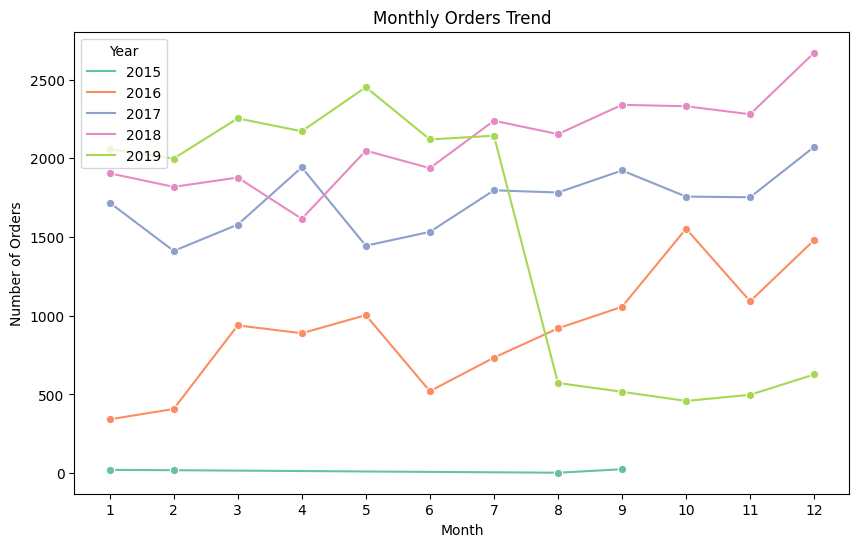

In [12]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year

monthly_orders = df.groupby(['Year', 'Month']).size().reset_index(name='Orders')
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_orders, x='Month', y='Orders', hue='Year', marker='o', palette='Set2')
plt.title('Monthly Orders Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.show()


Menampilkan jumlah order perhari

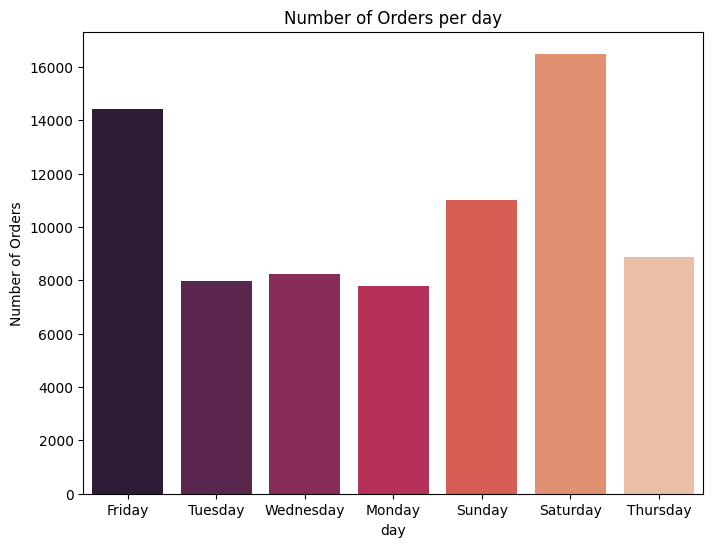

In [13]:
df['name day'] = df['Order Date'].dt.day_name()

plt.figure(figsize=(8, 6))
sns.countplot(x='name day', data=df, palette='rocket')
plt.title('Number of Orders per day')
plt.xlabel('day')
plt.ylabel('Number of Orders')
plt.show()

Menampilkan jumlah order perbulan

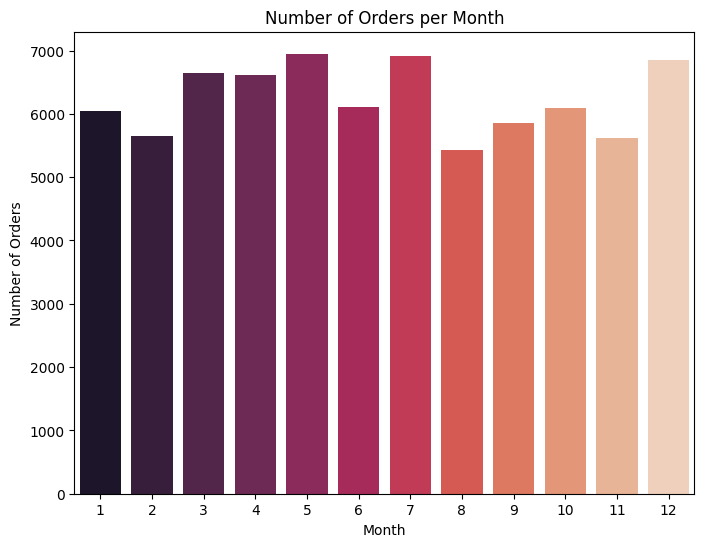

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Month', data=df, palette='rocket')
plt.title('Number of Orders per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

Menampilkan jumlah order pertahun

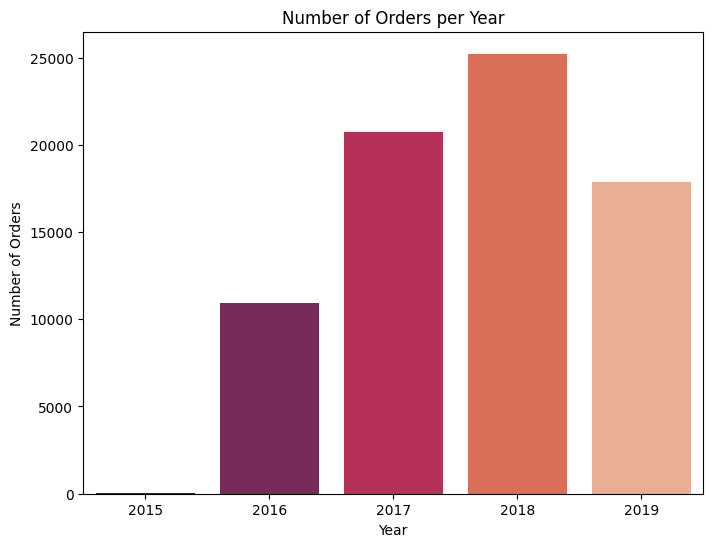

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Year', data=df, palette='rocket')
plt.title('Number of Orders per Year')
plt.xlabel('Year')
plt.ylabel('Number of Orders')
plt.show()

Menampilkan boxplot distribusi harga, dapat disimpulkan bahwa sebagian besar produk memiliki harga yang relatif murah.

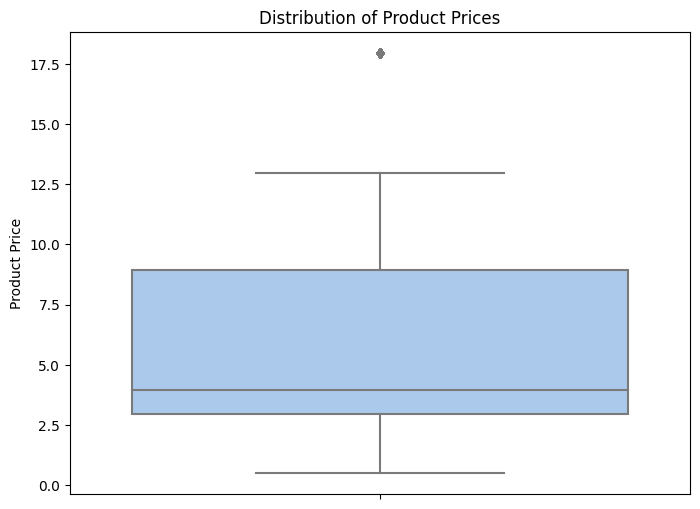

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='Product Price', data=df, palette='pastel')
plt.title('Distribution of Product Prices')
plt.ylabel('Product Price')
plt.show()

# Preprocessing

In [17]:
df["Order Date"].dtype

dtype('<M8[ns]')

Menambahkan kolom "month", "day", dan "hour", dengan nilai-nilai yang diambil dari kolom "Order Date"

In [18]:
df["month"] = df["Order Date"].dt.month
df["day"] = df["Order Date"].dt.weekday
df["hour"] = df["Order Date"].dt.hour
df.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products,Month,Year,name day,month,day,hour
0,16118,2019-03-08 20:25:00,Plain Papadum,2,0.80,6,3,2019,Friday,3,4,20
1,16118,2019-03-08 20:25:00,King Prawn Balti,1,12.95,6,3,2019,Friday,3,4,20
2,16118,2019-03-08 20:25:00,Garlic Naan,1,2.95,6,3,2019,Friday,3,4,20
3,16118,2019-03-08 20:25:00,Mushroom Rice,1,3.95,6,3,2019,Friday,3,4,20
4,16118,2019-03-08 20:25:00,Paneer Tikka Masala,1,8.95,6,3,2019,Friday,3,4,20


Membuat data frame baru yang berisi Order Number, Item name dan quantity

In [19]:
data = df[["Order Number", "Item Name", "Quantity"]].copy()
data.head()

,Order Number,Item Name,Quantity
0,16118,Plain Papadum,2
1,16118,King Prawn Balti,1
2,16118,Garlic Naan,1
3,16118,Mushroom Rice,1
4,16118,Paneer Tikka Masala,1


 Membuat sebuah pivot table dari dataframe data yang menghitung jumlah Quantity untuk setiap Item name dalam setiap order number

In [20]:
item_count_pivot = data.pivot_table(index="Order Number", columns="Item Name", values="Quantity", aggfunc="sum").fillna(0)
print("Ukuran dataset : ", item_count_pivot.shape)
item_count_pivot.head()

Ukuran dataset :  (13397, 248)


Item Name,Aloo Chaat,Aloo Gobi,Aloo Methi,Baingan Hari Mirch,Bengal Fish Biryani,Bengal Fish Karahi,Bengal Fry Fish,Bengal King Prawn,Bengal Salad,Bhindi Bhajee,...,Vegetable Rice,Vegetable Roll,Vegetable Samosa,Vindaloo,Vindaloo - Chicken,Vindaloo - Chicken Tikka,Vindaloo - King Prawn,Vindaloo - Lamb,Vindaloo - Prawn,Vindaloo Sauce
Order Number,,,,,,,,,,,,,,,,,,,,,
630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Konversi tipe data dari pivot table item_count_pivot menjadi int32

In [21]:
item_count_pivot = item_count_pivot.astype("int32")
item_count_pivot.head()

Item Name,Aloo Chaat,Aloo Gobi,Aloo Methi,Baingan Hari Mirch,Bengal Fish Biryani,Bengal Fish Karahi,Bengal Fry Fish,Bengal King Prawn,Bengal Salad,Bhindi Bhajee,...,Vegetable Rice,Vegetable Roll,Vegetable Samosa,Vindaloo,Vindaloo - Chicken,Vindaloo - Chicken Tikka,Vindaloo - King Prawn,Vindaloo - Lamb,Vindaloo - Prawn,Vindaloo Sauce
Order Number,,,,,,,,,,,,,,,,,,,,,
630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
def encode(x):
  if x <= 0:
    return 0
  elif x >= 1:
    return 1

item_count_pivot = item_count_pivot.applymap(encode)
item_count_pivot.head()

Item Name,Aloo Chaat,Aloo Gobi,Aloo Methi,Baingan Hari Mirch,Bengal Fish Biryani,Bengal Fish Karahi,Bengal Fry Fish,Bengal King Prawn,Bengal Salad,Bhindi Bhajee,...,Vegetable Rice,Vegetable Roll,Vegetable Samosa,Vindaloo,Vindaloo - Chicken,Vindaloo - Chicken Tikka,Vindaloo - King Prawn,Vindaloo - Lamb,Vindaloo - Prawn,Vindaloo Sauce
Order Number,,,,,,,,,,,,,,,,,,,,,
630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
print("Ukuran dataset : ", item_count_pivot.shape)
print("Ukuran Transaksi : ", item_count_pivot.shape[0])
print("Ukuran Item : ", item_count_pivot.shape[1])

Ukuran dataset :  (13397, 248)
Ukuran Transaksi :  13397
Ukuran Item :  248


# modeling

Menggunakan Algoritma Apriori untuk menemukan kumpulan item yang sering muncul berdasarkan nilai support

In [24]:
support = 0.01
frequent_items = apriori(item_count_pivot, min_support=support, use_colnames=True)
frequent_items.sort_values("support", ascending=False).head(10)

,support,itemsets
80,0.352392,(Pilau Rice)
81,0.280063,(Plain Naan)
82,0.268418,(Plain Papadum)
40,0.196163,(Garlic Naan)
72,0.179219,(Onion Bhajee)
83,0.176831,(Plain Rice)
28,0.159215,(Chicken Tikka Masala)
63,0.154438,(Mango Chutney)
324,0.133239,"(Pilau Rice, Plain Papadum)"
6,0.130776,(Bombay Aloo)


# Visualisasi hasil algoritma

Akhirnya, jadi hasil dari algoritma apriori kita mendapatkan baris-baris data yang memilki aturan aturan sepert support, confidence dll

In [25]:
metric = "lift"
min_threshold = 1

rules = association_rules(frequent_items, metric=metric, min_threshold=min_threshold)[["antecedents", "consequents", "support", "confidence", "lift"]]

rules.sort_values("confidence", ascending=False, inplace=True)
rules.head(15)

,antecedents,consequents,support,confidence,lift
1775,"(Pilau Rice, Red Sauce, Mint Sauce)",(Plain Papadum),0.011719,0.951515,3.544897
1847,"(Red Sauce, Mint Sauce, Onion Chutney, Mango C...",(Plain Papadum),0.010002,0.950355,3.540573
1707,"(Onion Bhajee, Mint Sauce, Onion Chutney)",(Plain Papadum),0.011868,0.940828,3.505083
1483,"(Mint Sauce, Onion Chutney, Mango Chutney)",(Plain Papadum),0.021049,0.930693,3.467323
1817,"(Pilau Rice, Mint Sauce, Onion Chutney, Mango ...",(Plain Papadum),0.010898,0.929936,3.464504
1301,"(Mint Sauce, Bombay Aloo, Mango Chutney)",(Plain Papadum),0.010674,0.928571,3.459419
1734,"(Pilau Rice, Mint Sauce, Onion Chutney)",(Plain Papadum),0.015824,0.925764,3.448961
1749,"(Red Sauce, Mint Sauce, Onion Chutney)",(Plain Papadum),0.015078,0.918182,3.420712
1343,"(Chicken Tikka Masala, Mint Sauce, Mango Chutney)",(Plain Papadum),0.010674,0.910828,3.393316
1553,"(Red Sauce, Mint Sauce, Mango Chutney)",(Plain Papadum),0.014182,0.904762,3.370716


# save model (pickle)